In [76]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os import path
import math 
from collections import defaultdict

import sys
sys.path.insert(0, path.abspath(path.join(path.curdir, '../src')))

%matplotlib notebook

In [2]:
# READ DATA: Blade landings 

blade_landings= pd.read_csv('blade_landing_helihoist_sbitroot.txt')

# make epoch index of dataframe and convert epoch into readable dates
blade_landings.epoch_land= blade_landings.epoch_land.apply(lambda x: pd.to_datetime(x, unit= 's', utc=True))

# convert blade landings of turbine 8 into readable dates
blade_landing1= pd.to_datetime(1.571127e+09	, unit='s', utc=True)
blade_landing2= pd.to_datetime(1.571154e+09, unit='s', utc=True)
blade_landing3= pd.to_datetime(1.571188e+09, unit='s', utc=True)

landings = (blade_landing1, blade_landing2, blade_landing3)

In [3]:
# READ CSV files of GPS Data: turbine 8

# sbitroot
gps_sbitroot_tb8= pd.read_csv('turbine-08_sbitroot_tom_gps.csv')
gps_sbitroot_tb8.epoch= pd.to_datetime(gps_sbitroot_tb8.epoch, unit= 's', utc=True)
gps_sbitroot_tb8.set_index('epoch', inplace=True)

# sbittip
gps_sbittip_tb8= pd.read_csv('turbine-08_sbittip_tom_gps.csv')
gps_sbittip_tb8.epoch= pd.to_datetime(gps_sbittip_tb8.epoch, unit= 's', utc=True)
gps_sbittip_tb8.set_index('epoch', inplace=True)

# helihoist
gps_helih_tb8= pd.read_csv('turbine-08_helihoist-1_tom_gps.csv')
gps_helih_tb8.epoch= pd.to_datetime(gps_helih_tb8.epoch, unit= 's', utc=True)
gps_helih_tb8.set_index('epoch', inplace=True)

In [4]:
# Find blade installation period in data

hub_height = 90 # hub height = 90m

# smoothing the time series: cut the outliers and find the 20min mean value
hh, sr, st = (gps_helih_tb8.altitude.resample('1s').mean().rolling('20min').mean(), gps_sbitroot_tb8.altitude.resample('1s').mean().rolling('20min').mean(), gps_sbittip_tb8.altitude.resample('1s').mean().rolling('20min').mean())

hh_sbi = hh[(hh > hub_height) & (sr > hub_height) & (st > hub_height)]
sr_sbi = sr[(hh > hub_height) & (sr > hub_height) & (st > hub_height)]
st_sbi = st[(hh > hub_height) & (sr > hub_height) & (st > hub_height)]

# determine start and end period of single blade installations
inst_period = sr_sbi[sr_sbi.index.to_series().diff() > pd.to_timedelta(60, unit='s')].index.to_list()
inst_period.insert(0, sr_sbi.index[0])
inst_period.insert(len(inst_period), sr_sbi.index[-1])
sbi_indices = list()

for i in range(len(inst_period) - 1):
    sbi_indices.append((inst_period[i], hh_sbi[inst_period[i]:inst_period[i+1]].index[-2]))

In [5]:
# concatenate csv data of helihoist 

path_hh = r'/Users/lenastroer/Python_Lokal/MasterThese/tb8/Blade_Landings/Helihoist'
hh_files = glob(path_hh + "/*.csv")

hh_data_tb8 = []

for filename in hh_files:
    hh_df = pd.read_csv(filename, index_col=None, header=0)
    hh_data_tb8.append(hh_df)

hh_frame = pd.concat(hh_data_tb8, axis=0, ignore_index=True)

hh_frame.epoch= pd.to_datetime(hh_frame.epoch, unit= 's', utc=True)
hh_frame.set_index('epoch', inplace=True)
hh_frame = hh_frame.sort_index()

# concatenate csv data of sbitroot

path_sbitroot = r'/Users/lenastroer/Python_Lokal/MasterThese/tb8/Blade_Landings/sbitroot'
sbitroot_files = glob(path_sbitroot + "/*.csv")

sbitroot_data_tb8 = []

for filename in sbitroot_files:
    sbitroot_df = pd.read_csv(filename, index_col=None, header=0)
    sbitroot_data_tb8.append(sbitroot_df)

sbitroot_frame = pd.concat(sbitroot_data_tb8, axis=0, ignore_index=True)

sbitroot_frame.epoch= pd.to_datetime(sbitroot_frame.epoch, unit= 's', utc=True)
sbitroot_frame.set_index('epoch', inplace=True)
sbitroot_frame = sbitroot_frame.sort_index()

# concatenate csv data of sbittip

path_sbittip = r'/Users/lenastroer/Python_Lokal/MasterThese/tb8/Blade_Landings/sbittip'
sbittip_files = glob(path_sbittip + "/*.csv")

sbittip_data_tb8 = []

for filename in sbittip_files:
    sbittip_df = pd.read_csv(filename, index_col=None, header=0)
    sbittip_data_tb8.append(sbittip_df)

sbittip_frame = pd.concat(sbittip_data_tb8, axis=0, ignore_index=True)

sbittip_frame.epoch= pd.to_datetime(sbittip_frame.epoch, unit= 's', utc=True)
sbittip_frame.set_index('epoch', inplace=True)
sbittip_frame = sbittip_frame.sort_index()

In [6]:
# READ ellipse data

# concatenate csv data of helihoist 

path_ellipse = r'/Users/lenastroer/Python_Lokal/MasterThese/tb8/Ellipses'
ellipse_files = glob(path_ellipse + "/*.csv")

ellipse_data_tb8 = []

for filename in ellipse_files:
    ellipse_df = pd.read_csv(filename, index_col=None, header=0)
    ellipse_data_tb8.append(ellipse_df)

ellipse_frame = pd.concat(ellipse_data_tb8, axis=0, ignore_index=True)

ellipse_frame.epoch= pd.to_datetime(ellipse_frame.epoch, unit= 's', utc=True)
ellipse_frame.set_index('epoch', inplace=True)
ellipse_frame = ellipse_frame.sort_index()

# IMPACTS

In [7]:
# Filter out outliers from acceleration measurement

# SBIT root 
median_x = sbitroot_frame.loc[sbitroot_frame['acc_x']<10, 'acc_x'].median()
median_z = sbitroot_frame.loc[sbitroot_frame['acc_z']<10, 'acc_z'].median()

sbitroot_frame['acc_x'] = np.where(sbitroot_frame["acc_x"] >10, median_x,sbitroot_frame['acc_x'])
sbitroot_frame['acc_x'] = np.where(sbitroot_frame["acc_x"] < -10 , median_x,sbitroot_frame['acc_x'])

sbitroot_frame['acc_z'] = np.where(sbitroot_frame["acc_z"] >10, median_z,sbitroot_frame['acc_z'])
sbitroot_frame['acc_z'] = np.where(sbitroot_frame["acc_z"] < -10 , median_z,sbitroot_frame['acc_z'])

In [8]:
# Find independent oscillation periods

acc_threshold_x = 0.5 #acceleration threshold (m/s^2)
acc_threshold_z = 0.5
acc_threshold_y = 0.3

limit = pd.to_timedelta(60, unit='s') #time limit to avoid correlation
min_impact_time = pd.to_timedelta(10, unit='s') # minimum time of impact event, erasing measurment errors

sbitroot_installation = pd.DataFrame()

# determine the installation times (blade at hub height) in the acceleration data 

for start, end in sbi_indices:
    sbitroot_installation = sbitroot_installation.append(sbitroot_frame[start:end])

## X Direction

In [9]:
# find start values of impact event

sbitroot_ind = sbitroot_installation.acc_x[(abs(sbitroot_installation.acc_x) > acc_threshold_x) & (abs(sbitroot_installation.acc_y) > acc_threshold_y)]

# find the indices where the difference is bigger than the time limit (avoid correlation)

deltaT_startImpact = sbitroot_ind[sbitroot_ind.index.to_series().diff() > limit].index.to_list()

# find the points in time where the threshold is exceeded (start of the impact event)
# add the start of the first impact event
deltaT_startImpact.insert(0, sbitroot_ind.index[0])

#print(f'deltaT start impact: {deltaT_startImpact}')

In [10]:
# find end values of impact event

sbitroot_ind_inverse = sbitroot_ind.sort_index(ascending=False)

# find the indices where the difference is bigger than the time limit (avoid correlation)

deltaT_endImpact = sbitroot_ind_inverse[sbitroot_ind_inverse.index.to_series().diff() < -limit].index.to_list()

# find the points in time where the threshold is exceeded (start of the impact event)
# add the end of the last impact event
deltaT_endImpact.insert(0, sbitroot_ind_inverse.index[0])
deltaT_endImpact.sort(reverse=False)


#print(f'deltaT end impact: {deltaT_endImpact}')

In [11]:
impact_times_x = list()

for i in range(len(deltaT_endImpact) ): 
    if (deltaT_endImpact[i]- deltaT_startImpact[i]) > min_impact_time :
        # filter out measurement errors
        impact_times_x.append((deltaT_startImpact[i], deltaT_endImpact[i]))

#print(impact_times)
n_impacts_x = len(impact_times_x)

## Z Direction

In [12]:
# find start values of impact event

sbitroot_ind = sbitroot_installation.acc_z[(abs(sbitroot_installation.acc_z) > acc_threshold_z)& (abs(sbitroot_installation.acc_y) > acc_threshold_y)]

# find the indices where the difference is bigger than the time limit (avoid correlation)

deltaT_startImpact = sbitroot_ind[sbitroot_ind.index.to_series().diff() > limit].index.to_list()

# find the points in time where the threshold is exceeded (start of the impact event)
# add the start of the first impact event
deltaT_startImpact.insert(0, sbitroot_ind.index[0])

#print(f'deltaT start impact: {deltaT_startImpact}')

In [13]:
# find end values of impact event

sbitroot_ind_inverse = sbitroot_ind.sort_index(ascending=False)

# find the indices where the difference is bigger than the time limit (avoid correlation)

deltaT_endImpact = sbitroot_ind_inverse[sbitroot_ind_inverse.index.to_series().diff() < -limit].index.to_list()

# find the points in time where the threshold is exceeded (start of the impact event)
# add the end of the last impact event
deltaT_endImpact.insert(0, sbitroot_ind_inverse.index[0])
deltaT_endImpact.sort(reverse=False)


#print(f'deltaT end impact: {deltaT_endImpact}')

In [14]:
impact_times_z = list()

for i in range(len(deltaT_endImpact) ): 
    if (deltaT_endImpact[i]- deltaT_startImpact[i]) > min_impact_time :
        # filter out measurement errors
        impact_times_z.append((deltaT_startImpact[i], deltaT_endImpact[i]))

# INDEPENDENT movements

In [15]:
# Impact times combined

impact_times = impact_times_z + impact_times_x
impact_times.sort()
#print(impact_times)

In [16]:
inst_stages= []
for start, end in sbi_indices:
    inst_stages.append (sbitroot_frame[start:end].acc_x)

#print(inst_stages)

In [47]:
# Find start values of sbi and impacts

sbi_indices_start = [i[0] for i in sbi_indices]
impact_times_start = [i[0] for i in impact_times]

In [48]:
# identify period from start sbi-period to first impact = INDEPENDENT OSCILLATION
# write first impacts after start of blade installation into list
# to identify independent oscillations, timestamp of impact needs to be bigger than timestamp of sbi-period
# timestamp of impact needs to be the first impact after sbi-period

# indices of first impacts
first_impacts = []
# timestamp of first impacts
first_impacts_start = []

for i in range (len(sbi_indices_start)):
        first_impacts.append(next(x for x, val in enumerate(impact_times_start)
                                  if val > sbi_indices_start[i]))

for i in range(len(sbi_indices_start)):
    first_impacts_start.append(impact_times_start[first_impacts[i]])

In [49]:
independent_osc = []
for i in range (len(sbi_indices_start)):
        independent_osc.append(sbitroot_installation.acc_z[sbi_indices_start[i]:impact_times_start[first_impacts[i]]])

<IPython.core.display.Javascript object>


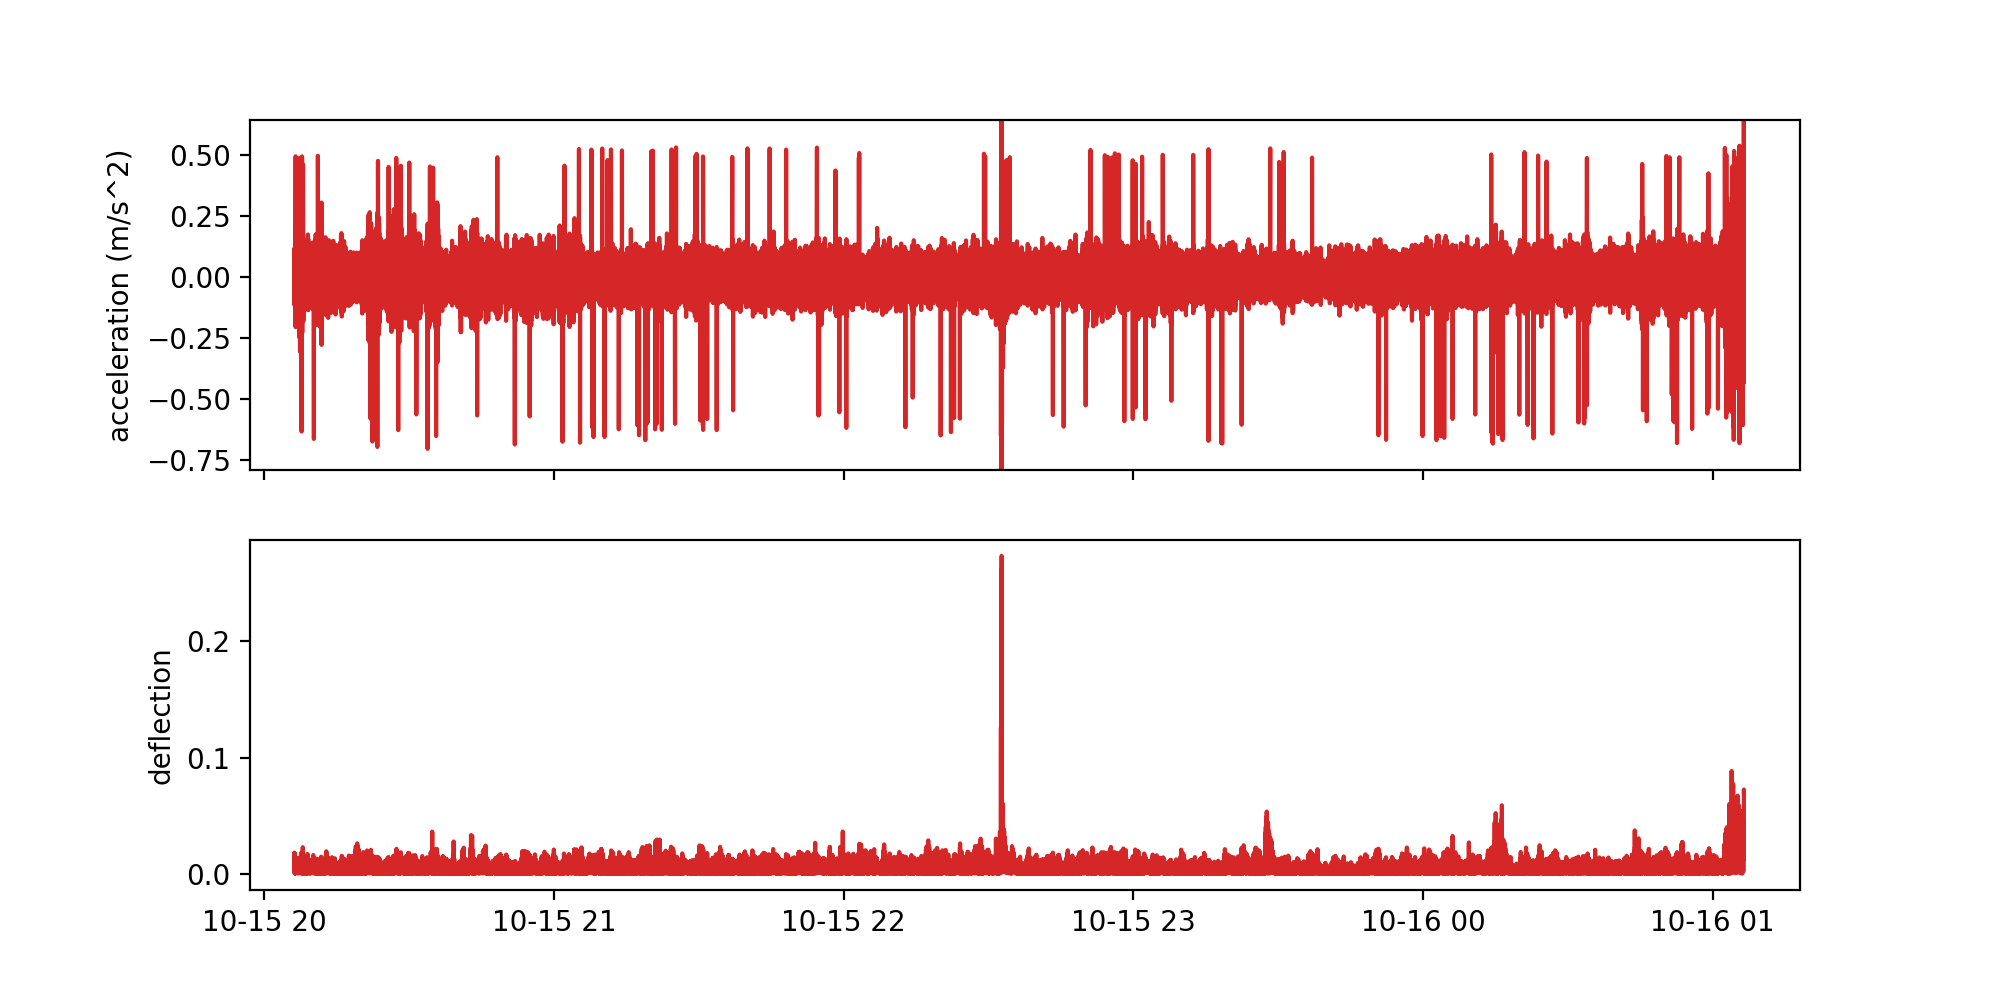

Text(0, 0.5, 'deflection')

In [50]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10, 5))

for i in range(len(first_impacts)):
    ax1.plot(independent_osc[i], label='independent accelerations')   
ax1.set_ylabel('acceleration (m/s^2)')

for j in range(len(first_impacts)):
    ax2.plot(sbitroot_installation.deflection[sbi_indices_start[j]:impact_times_start[first_impacts[j]]], label='axis_ratio')
ax2.set_ylabel('deflection')  

In [51]:
indep_deflection = []
for j in range(len(first_impacts)):
    indep_deflection.append(sbitroot_installation.deflection[sbi_indices_start[j]:impact_times_start[first_impacts[j]]])

In [56]:
print(sbi_indices_start)
print(first_impacts_start)

2019-10-15 06:32:25+00:00
2019-10-15 07:04:47.648999936+00:00


In [79]:
# calculate number of chunks for each independent interval 
# number of chunks is the length of the independent interval divided by the time interval
# therfore, the start value minus the end value of the independent interval is the time difference 

time_interval = pd.to_timedelta(60, unit='s')

indep_duration = []
for i in range(len(sbi_indices_start)):
    indep_duration.append(first_impacts_start[i] - sbi_indices_start[i])

num_chunks = []
for i in range(len(sbi_indices_start)):
    num_chunks.append(indep_duration[i]/time_interval)
    num_chunks[i] =  math.floor(num_chunks[i])

[32, 32, 130, 300]


In [82]:
def divide_chunks(l, n):
      
    # looping till length l
    for i in range(0, len(l), n): 
        yield l[i:i + n]

In [84]:
indep_blocks = []
for i in range(len(num_chunks)):
    indep_blocks.append(divide_chunks(indep_deflection[i],num_chunks[i]))
print(indep_blocks)

[<generator object divide_chunks at 0x7fab88ce3970>, <generator object divide_chunks at 0x7fab88ce3b30>, <generator object divide_chunks at 0x7fab88ce3c10>, <generator object divide_chunks at 0x7fab88ce3c80>]
